**Eugen Ehrlich im Web of Science und in OpenAlex**

This notebook ...

# Preparation

In [ ]:
# Uncomment and run once
# if you use vanilla python:
#   !pip install py2neo python-dotenv pandas pyvis
# OR if you use anaconda:
#   !conda install -c conda-forge py2neo python-dotenv
#   !conda install panda pyvis
# for table of contents support, see https://github.com/ipython-contrib/jupyter_contrib_nbextensions

Import the required libraries and setup needed objects:

In [1]:
# config
from dotenv import dotenv_values
config = {**dotenv_values()}

# https://py2neo.org/v4/
from py2neo import Graph, Node, Relationship
graph = Graph(config['NEO4J_URL'])

# visualization
from scripts.vis import draw, table

# clean up visualization HTML dir


# Web of Science

KB -> Neo4J

## Overview

In [2]:
cypher = """
use `ehrlich-wos`
match (a1:Author)-[r1:CREATOR_OF]->(w1:Work)<-[r2:CITES]-(w2:Work)<-[r3:CREATOR_OF]-(a2:Author)
where a1.display_name = "ehrlich, eugen"
return count(distinct w1) as works_cited,
    count(distinct r2) as num_citations,
    count(distinct w2) as citing_works,
    count(distinct a2) as citing_authors
"""
graph.run(cypher).data()

[{'works_cited': 33,
  'num_citations': 34,
  'citing_works': 25,
  'citing_authors': 37}]

## Cited works

In [ ]:
cypher = """
use `ehrlich-wos`
match (a1:Author)-[r1:CREATOR_OF]->(w1:Work)<-[r2:CITES]-(w2:Work)<-[r3:CREATOR_OF]-(a2:Author)
where a1.display_name = "ehrlich, eugen"
return distinct a1.display_name as author, w1.year as year, w1.title as title order by w1.year
"""
graph.run(cypher).to_data_frame()

## Citing works

In [ ]:
cypher = """
use `ehrlich-wos`
MATCH (a1:Author)-[:CREATOR_OF]->(w1:Work)<-[:CITES]-(w2:Work)<-[:CREATOR_OF]-(a2:Author)
WHERE a1.display_name = "ehrlich, eugen"
WITH w2, COLLECT(a2)[0] AS first_author
RETURN first_author.display_name AS author, w2.year AS year, w2.title AS title
ORDER BY w2.year
"""
graph.run(cypher).to_data_frame()

# OpenAlex

openalex.org -> neo4j

## Overview

In [ ]:
cypher = """
use `ehrlich-openalex`
match (a1:Author)-[r1:CREATOR_OF]->(w1:Work)<-[r2:CITES]-(w2:Work)<-[r3:CREATOR_OF]-(a2:Author)
where a1.display_name = "ehrlich, eugen"
return count(distinct w1) as works_cited,
    count(distinct r2) as num_citations,
    count(distinct w2) as citing_works,
    count(distinct a2) as citing_authors
"""
graph.run(cypher).data()

## Cited works
### All years

In [ ]:
query = """
match (a1:Author)-[r1:CREATOR_OF]->(w1:Work)<-[r2:CITES]-(w2:Work)<-[r3:CREATOR_OF]-(a2:Author)
match (w1)-[r4:PUBLISHED_IN]->(v1:Venue)
where a1.display_name = "ehrlich, eugen"
return distinct
    a1.display_name as author,
    w1.year as year,
    w1.title as title,
    v1.name as container,
    count(r2) as citations
order by citations desc
"""
graph = Graph(config['NEO4J_URL'], name="ehrlich-openalex")
graph.run(query).to_data_frame()

### Cited works (1960-1989)

In [ ]:
query = """
match (a1:Author)-[r1:CREATOR_OF]->(w1:Work)<-[r2:CITES]-(w2:Work)<-[r3:CREATOR_OF]-(a2:Author)
where a1.display_name = "ehrlich, eugen" and w2.year >= 1960 and w2.year <= 1990
return distinct
    a1.display_name as author,
    w1.year as year,
    w1.title as title,
    count(r2) as citations
order by citations desc
"""
graph = Graph(config['NEO4J_URL'], name="ehrlich-openalex")
graph.run(query).to_data_frame()

### Graph: Cited works, over time

OpenAlex seems not to distinguish between different editions of a work - e.g. ehrlich (1989) is cited even before publication. Also, book reviews are included (like the one by timasheff).

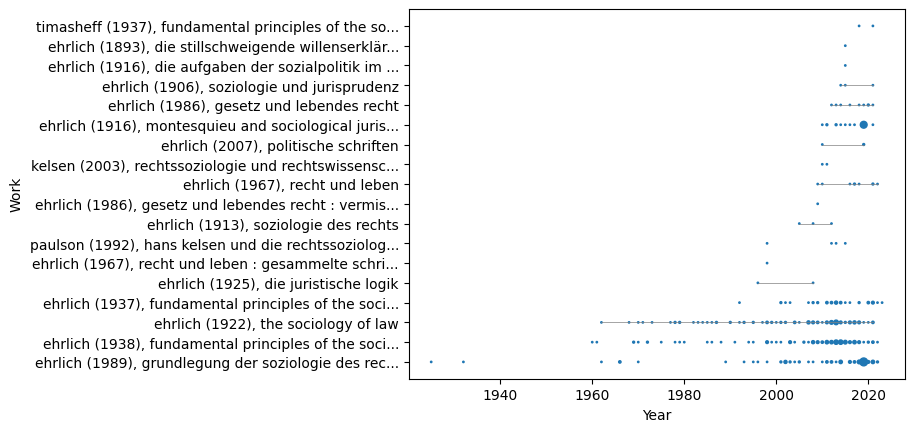

In [64]:
query = """
MATCH (citingWork:Work)-[r:CITES]->(citedWork:Work)<-[:CREATOR_OF]-(citedAuthor:Author)
WHERE citedAuthor.display_name = "ehrlich, eugen"
RETURN citedWork.display_name as work, citingWork.year as year, count(*) as citations
ORDER BY year
"""
from scripts.n4j_plotlib import plot_year_citations
graph = Graph(config['NEO4J_URL'], name="ehrlich-openalex")
data = graph.run(query).data()
plot_year_citations(data, dep_col='work', dep_label='Work')

## Citing works
### Citing works (1960-1989)

In [ ]:
cypher = """
MATCH (a1:Author)-[:CREATOR_OF]->(w1:Work)<-[:CITES]-(w2:Work)<-[:CREATOR_OF]-(a2:Author)
WHERE a1.display_name = "ehrlich, eugen" and w2.year > 1967 and w2.year < 1990
WITH w1, w2, COLLECT(a2)[0] AS first_author
RETURN
    first_author.display_name AS author,
    w2.year AS year,
    w2.title AS title,
    w1.title as cited_work
ORDER BY w2.year
"""
graph = Graph(config['NEO4J_URL'], name="ehrlich-openalex")
graph.run(cypher).to_data_frame()

### Citing works (all years)

In [ ]:
cypher = """
MATCH (a1:Author)-[:CREATOR_OF]->(w1:Work)<-[:CITES]-(w2:Work)<-[:CREATOR_OF]-(a2:Author)
WHERE a1.display_name = "ehrlich, eugen"
WITH w1, w2, COLLECT(a2)[0] AS first_author
RETURN
    first_author.display_name AS author,
    w2.year AS year,
    w2.title AS title,
    w1.title as cited_work
ORDER BY w2.year
"""
graph = Graph(config['NEO4J_URL'], name="ehrlich-openalex")
graph.run(cypher).to_data_frame()

## Citing journals
### Citing journals, all years

In [ ]:
query = """
MATCH (a1:Author)-[r1:CREATOR_OF]->(w1:Work)<-[r2:CITES]-(w2:Work)-[r3:PUBLISHED_IN]-(v1:Venue)
WHERE a1.display_name = "ehrlich, eugen"
with w1, v1, count(r2) as num_citations
where num_citations > 1
RETURN  v1.name AS container,
        num_citations,
        w1.title as cited_work
order by num_citations desc
"""
graph = Graph(config['NEO4J_URL'], name="ehrlich-openalex")
graph.run(query).to_data_frame()

### Graph: Citing journal, all years

In [5]:
query = """
MATCH (a1:Author)-[r1:CREATOR_OF]->(w1:Work)<-[r2:CITES]-(w2:Work)-[r3:PUBLISHED_IN]-(v1:Venue)
WHERE a1.display_name = "ehrlich, eugen"
with w1, v1, count(r2) as num_citations
where num_citations > 1
RETURN  v1 AS source_node,
        apoc.create.vRelationship(v1, 'CITATIONS', {value:num_citations}, w1) as rel,
        w1 as target_node
"""
graph = Graph(config['NEO4J_URL'], name="ehrlich-openalex")
# graph.run(query).to_data_frame()
# options = {"Author": "display_name",
#            "Work": "display_name",
#            "Venue": "name",
#            "CITATIONS":"value"}
# draw(graph, query, options, physics=True)
#graph = Graph(config['NEO4J_URL'], name="ehrlich-openalex")
from scripts.pyvis import draw
draw(graph, query)

In [62]:
query = """
MATCH (a1:Author)-[r1:CREATOR_OF]->(w1:Work)<-[r2:CITES]-(w2:Work)-[r3:PUBLISHED_IN]-(v1:Venue)
WHERE a1.display_name = "ehrlich, eugen" and w2.year > 1960 and w2.year < 1990
with w1, v1, count(r2) as num_citations
where num_citations > 1
RETURN  v1 AS source_node,
        apoc.create.vRelationship(v1, 'CITATIONS', {value:num_citations}, w1) as rel,
        w1 as target_node
"""
graph = Graph(config['NEO4J_URL'], name="ehrlich-openalex")
import scripts.pyvis
scripts.pyvis.draw(graph, query)

## Citing authors,
### Citing authors, 1960-1989

In [63]:
query = """
MATCH (a1:Author)-[r1:CREATOR_OF]->(w1:Work)<-[r2:CITES]-(w2:Work)<-[r3:CREATOR_OF]-(a2:Author)
WHERE a1.display_name = "ehrlich, eugen" and w2.year > 1960 and w2.year < 1990
with a1, a2, count(r2) as num_citations
//where num_citations > 1
RETURN  a2 AS source_node,
        apoc.create.vRelationship(a2, 'CITES', {value:num_citations}, a1) as rel,
        a1 as target_node
"""
#options = {"Author": "display_name", "Work": "display_name", "Venue": "name", "CITES":"value"}
#draw(graph, query, options, physics=True, db="ehrlich-openalex")
graph = Graph(config['NEO4J_URL'], name="ehrlich-openalex")
import scripts.pyvis
scripts.pyvis.draw(graph, query)

### Graph: Citing authors, at least 5 citations over more than one year

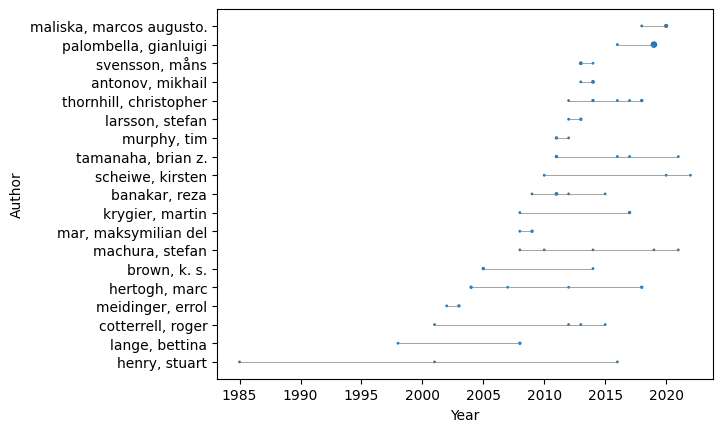

In [4]:
query = """
MATCH (a1:Author)-[:CREATOR_OF]->(w1:Work)-[r:CITES]->(w2:Work)<-[:CREATOR_OF]-(a2:Author)
WHERE a1.display_name <> ", " and a2.display_name = "ehrlich, eugen"
WITH a1, a2, count(r) as total_citations, collect(DISTINCT w1.year) as years
WHERE size(years) > 1 and total_citations >= 3
MATCH (a1)-[:CREATOR_OF]->(w1:Work)-[r:CITES]->(w2:Work)<-[:CREATOR_OF]-(a2)
RETURN a1.display_name as author, w1.year as year, count(r) as citations
ORDER BY year
"""
from scripts.n4j_plotlib import plot_year_citations
graph = Graph(config['NEO4J_URL'], name="ehrlich-openalex")
data = graph.run(query).data()
plot_year_citations(data)


## Co-Citations

### Most co-cited authors

In [6]:
query = """
USE `ehrlich-openalex`
MATCH (citedAuthor:Author)-[:CREATOR_OF]->(citedWork:Work)<-[:CITES]-(citingWork:Work),
      (citingWork)-[:CITES]->(coCitedWork:Work)<-[:CREATOR_OF]-(coCitedAuthor:Author)
WHERE citedAuthor.display_name = "ehrlich, eugen" and coCitedAuthor.display_name <> ", "
WITH coCitedAuthor, COUNT(distinct coCitedWork) as coCitationCount
ORDER BY coCitationCount DESC
LIMIT 10
RETURN coCitedAuthor.display_name as Author,
    coCitationCount as CoCitationCount
"""
graph.run(query).to_table()

Author,CoCitationCount
"teubner, gunther",51
"luhmann, niklas",35
"tyler, tom r.",33
"cotterrell, roger",30
"weber, max",29
"kelsen, hans",29
"pound, roscoe",28
"nelken, david",27
"machura, stefan",26
"lind, e. allan",26


### Most co-cited authors with most-cited works in the co-citation

In [7]:
query="""
MATCH (citingWork:Work)-[:CITES]->(citedWork:Work)<-[:CREATOR_OF]-(citedAuthor:Author),
      (citingWork)-[:CITES]->(coCitedWork:Work)<-[:CREATOR_OF]-(coCitedAuthor:Author)
where citedAuthor.display_name = "ehrlich, eugen" and coCitedAuthor.display_name <> ", "
WITH citedAuthor, coCitedAuthor,
    COUNT(distinct coCitedWork) as coCitationCount,
    collect(distinct citedWork) as citedWorks,
    collect(distinct coCitedWork) as coCitedWorks
ORDER BY coCitationCount DESC
LIMIT 10
call {
    with citedWorks, coCitedWorks
    unwind citedWorks as citedWork
    unwind coCitedWorks as coCitedWork
    MATCH (citingWork:Work)-[:CITES]->(citedWork)
    where exists((citingWork)-[:CITES]->(coCitedWork))
    with citedWork, count(citedWork) as citedWorkCitedCount
    ORDER BY citedWorkCitedCount DESC
    LIMIT 1
    return citedWork as mostCitedCitedWork
}
call {
    with citedWorks, coCitedWorks
    unwind citedWorks as citedWork
    unwind coCitedWorks as coCitedWork
    MATCH (citingWork:Work)-[:CITES]->(coCitedWork)
    where exists((citingWork)-[:CITES]->(citedWork))
    with coCitedWork, count(coCitedWork) as coCitationCitedCount
    ORDER BY coCitationCitedCount DESC
    LIMIT 1
    return coCitedWork as mostCitedCoCitedWork
}
return citedAuthor.display_name as `Cited Author`,
    coCitedAuthor.display_name as `Co-Cited Author`,
    coCitationCount as `Number of Co-Citations`,
    mostCitedCitedWork.display_name as `Most cited work of cited Author`,
    mostCitedCoCitedWork.display_name as `Most cited work of co-cited Author`
"""
graph = Graph(config['NEO4J_URL'], name="ehrlich-openalex")
graph.run(query).to_table()



Cited Author,Co-Cited Author,Number of Co-Citations,Most cited work of cited Author,Most cited work of co-cited Author
"ehrlich, eugen","teubner, gunther",51,"ehrlich (1989), grundlegung der soziologie des rechts.","teubner (2003), legal irritants: good faith in british law or how unifying law ends up in new divergencies"
"ehrlich, eugen","luhmann, niklas",35,"ehrlich (1938), fundamental principles of the sociology of law","luhmann (2004), law as a social system"
"ehrlich, eugen","tyler, tom r.",33,"ehrlich (1922), the sociology of law","tyler (2006), why people obey the law"
"ehrlich, eugen","cotterrell, roger",30,"ehrlich (1989), grundlegung der soziologie des rechts.","cotterrell (2015), does global legal pluralism need a concept of law?"
"ehrlich, eugen","weber, max",29,"ehrlich (1922), the sociology of law","weber (1981), economy and society: an outline of interpretive sociology"
"ehrlich, eugen","kelsen, hans",29,"ehrlich (1916), montesquieu and sociological jurisprudence","kelsen (1967), pure theory of law"
"ehrlich, eugen","pound, roscoe",28,"ehrlich (1938), fundamental principles of the sociology of law","ehrlich (1938), fundamental principles of the sociology of law"
"ehrlich, eugen","nelken, david",27,"ehrlich (1922), the sociology of law","nelken (1984), law in action or living law? back to the beginning in sociology of law"
"ehrlich, eugen","machura, stefan",26,"ehrlich (1938), fundamental principles of the sociology of law","röhl (2013), 100 jahre rechtssoziologie: eugen ehrlichs rechtspluralismus heute"
"ehrlich, eugen","lind, e. allan",26,"ehrlich (1922), the sociology of law","lind (1988), the social psychology of procedural justice"


# Eigene Daten

(description)

## Citing authors

### ZfRsoz

In [ ]:
query = """
MATCH (a1:Author)-[:CREATOR_OF]->(w1:Work)-[r:CITES]->(w2:Work)<-[:CREATOR_OF]-(a2:Author)
WITH a1, a2, count(r) as total_citations, collect(DISTINCT w1.year) as years
WHERE size(years) >= 1 and total_citations >= 1 and a2.display_name = "Ehrlich, Eugen"
MATCH (a1)-[:CREATOR_OF]->(w1:Work)-[r:CITES]->(w2:Work)<-[:CREATOR_OF]-(a2)
RETURN a1.display_name as author, w1.year as year, count(r) as citations
ORDER BY year
"""
from scripts.n4j_plotlib import plot_year_citations
graph = Graph(config['NEO4J_URL'], name="zfrsoz")
data = graph.run(query).data()
plot_year_citations(data)

### JLS

In [ ]:
query = """
MATCH (a1:Author)-[:CREATOR_OF]->(w1:Work)-[r:CITES]->(w2:Work)<-[:CREATOR_OF]-(a2:Author)
WITH a1, a2, count(r) as total_citations, collect(DISTINCT w1.year) as years
WHERE size(years) >= 1 and total_citations >= 1 and a2.display_name =~ "^ehrlich, e"
MATCH (a1)-[:CREATOR_OF]->(w1:Work)-[r:CITES]->(w2:Work)<-[:CREATOR_OF]-(a2)
RETURN a1.display_name as author, w1.year as year, count(r) as citations
ORDER BY year
"""
graph = Graph(config['NEO4J_URL'], name="jls")
data = graph.run(query).data()
plot_year_citations(data)

### ZfRsoz

In [ ]:
cypher = """
use `zfrsoz`
MATCH (a1:Author)-[:CREATOR_OF]->(w1:Work)<-[:CITES]-(w2:Work)<-[:CREATOR_OF]-(a2:Author)
WHERE a1.display_name =~ "Ehrlich, Eugen"
WITH w1, w2, COLLECT(a2)[0] AS first_author
RETURN
    first_author.display_name AS author,
    w2.year AS year,
    w2.title AS title,
    w1.title as cited_work
ORDER BY w2.year
"""
graph = Graph(config['NEO4J_URL'], name="zfrsoz")
data = graph.run(query).data()
plot_year_citations(data)

## Citing works, all years

In [ ]:
### JLS

In [ ]:
query = """
MATCH (a1:Author)-[:CREATOR_OF]->(w1:Work)<-[:CITES]-(w2:Work)<-[:CREATOR_OF]-(a2:Author)
WHERE a1.display_name =~ "^ehrlich, e"
WITH w1, w2, COLLECT(a2)[0] AS first_author
RETURN
    first_author.display_name AS author,
    w2.year AS year,
    w2.title AS title,
    w1.title as cited_work
ORDER BY w2.year
"""
graph = Graph(config['NEO4J_URL'], name="jls")
graph.run(query).to_data_frame()

### Zeitschrift für Rechtssoziologie

In [ ]:
graph = Graph(config['NEO4J_URL'], name="zfrsoz")
graph.run(query).to_data_frame()

### Lehrbücher

In [ ]:
graph = Graph(config['NEO4J_URL'], name="rsoz-lehrbuecher")
graph.run(query).to_data_frame()

### JLS

## Citing works

In [ ]:
query = """
MATCH (a1:Author)-[:CREATOR_OF]->(w1:Work)<-[:CITES]-(w2:Work)<-[:CREATOR_OF]-(a2:Author)
WHERE a1.family = "ehrlich" and a1.given starts with "e"
AND w2.year > 1960 and w2.year < 1990
WITH w2, COLLECT(a2)[0] AS first_author, COLLECT(w1)[0].title AS most_cited, count(w2) as count
RETURN
    first_author.display_name AS author,
    w2.year AS year,
    w2.title AS title,
    most_cited,
    count
ORDER BY count DESC, year
"""
graph = Graph(config['NEO4J_URL'], name="jls")
graph.run(query).to_table()


### Zeitschrift für Rechtssoziologie

In [ ]:
table(graph, query, db="zfrsoz")

### Lehrbücher

In [ ]:
table(graph, query, db="rsoz-lehrbuecher")

### JLS

In [ ]:
table(graph, query, db="jls")

## Authors citing Ehrlich, JLS

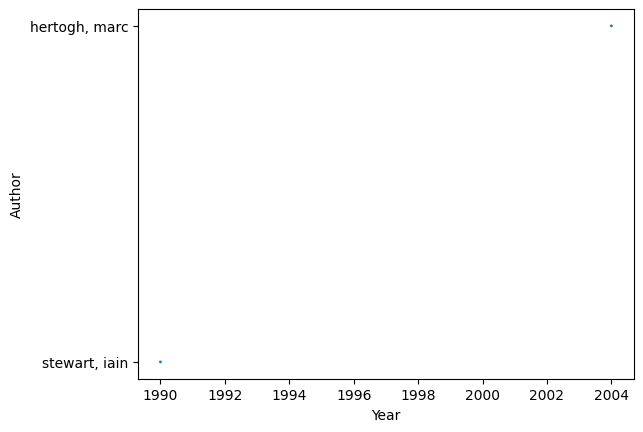

In [3]:
query = """
MATCH (a1:Author)-[:CREATOR_OF]->(w1:Work)-[r:CITES]->(w2:Work)<-[:CREATOR_OF]-(a2:Author)
WITH a1, a2, count(r) as total_citations, collect(DISTINCT w1.year) as years
WHERE size(years) >= 1 and total_citations >= 1 and a2.display_name =~ "^ehrlich, e"
MATCH (a1)-[:CREATOR_OF]->(w1:Work)-[r:CITES]->(w2:Work)<-[:CREATOR_OF]-(a2)
RETURN a1.display_name as author, w1.year as year, count(r) as citations
ORDER BY year
"""
graph = Graph(config['NEO4J_URL'], name="jls")
data = graph.run(query).data()
from scripts.n4j_plotlib import plot_year_citations
plot_year_citations(data)